In [1]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

%config Completer.use_jedi = False  # 자동완성 속도 증가

In [21]:
inputs = keras.Input(shape=(3,), name="my_input")
features = layers.Dense(64, activation="relu")(inputs)
outputs = layers.Dense(10, activation="softmax")(features)
model = keras.Model(inputs=inputs, outputs=outputs)

In [22]:
inputs.shape

TensorShape([None, 3])

In [23]:
inputs.dtype

tf.float32

In [24]:
features.shape

TensorShape([None, 64])

In [25]:
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 my_input (InputLayer)       [(None, 3)]               0         
                                                                 
 dense_6 (Dense)             (None, 64)                256       
                                                                 
 dense_7 (Dense)             (None, 10)                650       
                                                                 
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


### 다중 입력, 다중 출력 모델

In [3]:
# 다중 입력, 다중 출력 함수형 모델

vocabulary_size = 10000
num_tags = 100
num_departments = 4

# 모델 입력 정의
title = keras.Input(shape=(vocabulary_size,), name="title")
text_body = keras.Input(shape=(vocabulary_size,), name="text_body")
tags = keras.Input(shape=(num_tags,), name="tags")

# 입력 특성을 하나의 텐서 features로 연결
features = layers.Concatenate()([title, text_body, tags])

# 중간층을 적용하여 입력 특성을 더 풍부한 표현으로 재결합
features = layers.Dense(64, activation="relu")(features)

# 모델 출력 정의
priority = layers.Dense(1, activation="sigmoid", name="priority")(features)
department = layers.Dense(num_departments, activation="softmax", name="department")(
    features
)
# 입력과 출력을 지정하여 모델 생성
model = keras.Model(inputs=[title, text_body, tags], outputs=[priority, department])

### 다중 입력, 다중 출력 모델 훈련

In [4]:
#  입력과 타깃 배열 리스트를 전달하여 모델 훈련하기

num_samples = 1280

# 더미 입력 데이터 생성
title_data = np.random.randint(0, 2, size=(num_samples, vocabulary_size))
text_body_data = np.random.randint(0, 2, size=(num_samples, vocabulary_size))
tags_data = np.random.randint(0, 2, size=(num_samples, num_tags))

# 더미 타겟 데이터
priority_data = np.random.random(size=(num_samples, 1))
department_data = np.random.randint(0, 2, size=(num_samples, num_departments))

model.compile(
    optimizer="rmsprop",
    loss=["mean_squared_error", "categorical_crossentropy"],
    metrics=[["mean_absolute_error"], ["accuracy"]],
)

model.fit(
    [title_data, text_body_data, tags_data], [priority_data, department_data], epochs=1
)

model.evaluate(
    [title_data, text_body_data, tags_data], [priority_data, department_data]
)

priority_preds, department_preds = model.predict(
    [title_data, text_body_data, tags_data]
)

40/40 [==============================] - 1s 20ms/step - loss: 54.9687 - priority_loss: 0.3234 - department_loss: 54.6453 - priority_mean_absolute_error: 0.4916 - department_accuracy: 0.1305


In [28]:
#  입력과 타깃 배열을 딕셔너리로 전달하여 모델 훈련

model.compile(
    optimizer="rmsprop",
    loss={"priority": "mean_squared_error", "department": "categorical_crossentropy"},
    metrics={"priority": ["mean_absolute_error"], "department": ["accuracy"]},
)
model.fit(
    {"title": title_data, "text_body": text_body_data, "tags": tags_data},
    {"priority": priority_data, "department": department_data},
    epochs=1,
)
model.evaluate(
    {"title": title_data, "text_body": text_body_data, "tags": tags_data},
    {"priority": priority_data, "department": department_data},
)
priority_preds, department_preds = model.predict(
    {"title": title_data, "text_body": text_body_data, "tags": tags_data}
)

40/40 [==============================] - 1s 25ms/step - loss: 40.7219 - priority_loss: 0.3389 - department_loss: 40.3830 - priority_mean_absolute_error: 0.5109 - department_accuracy: 0.2648


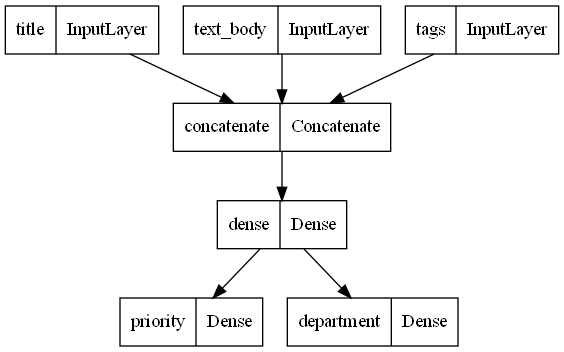

In [5]:
keras.utils.plot_model(model, "ticket_classifier.png")

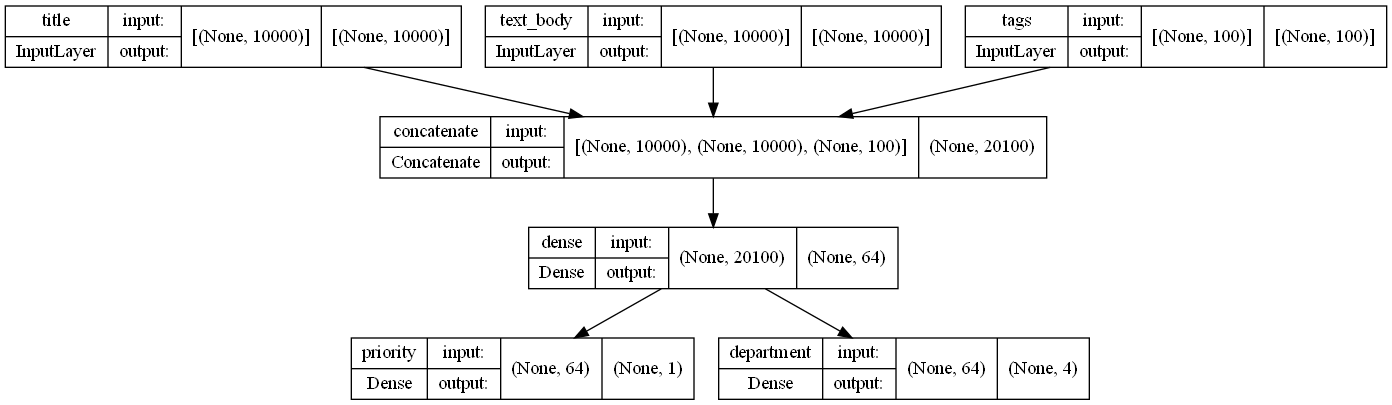

In [6]:
keras.utils.plot_model(model, "ticket_classifier_with_shape_info.png", show_shapes=True)

### 함수형 모델에 있는 층의 입력과 출력을 출력

In [7]:
model.layers

In [8]:
model.layers[3].input

[<KerasTensor: shape=(None, 10000) dtype=float32 (created by layer 'title')>,
 <KerasTensor: shape=(None, 10000) dtype=float32 (created by layer 'text_body')>,
 <KerasTensor: shape=(None, 100) dtype=float32 (created by layer 'tags')>]

In [9]:
model.layers[3].output

<KerasTensor: shape=(None, 20100) dtype=float32 (created by layer 'concatenate')>

In [10]:
#  중간층의 출력을 재사용해서 새로운 모델 생성
features = model.layers[4].output
difficulty = layers.Dense(3, activation="softmax", name="difficulty")(features)
new_model = keras.Model(
    inputs=[title, text_body, tags], outputs=[priority, department, difficulty]
)

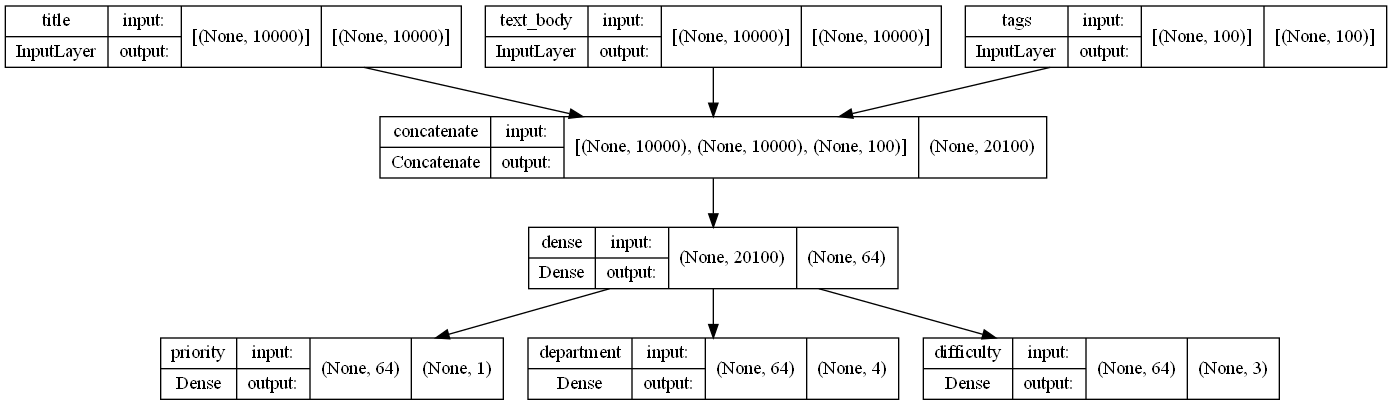

In [11]:
keras.utils.plot_model(new_model, "updated_ticket_classifier.png", show_shapes=True)

### Model SubClassing
- __init__() 메서드에서 모델이 사용할 층 정의
- call() 메서드에서 앞서 만든 층을 이용하여 모델의 정방향 패스를 정의
- 서브클래스의 객체를 만들고 데이터와 함께 호출하여 가중치 제작

In [12]:
# 간단한 서브클래싱 모델
class CustomerTicketModel(keras.Model):
    def __init__(self, num_departments):
        super().__init__()  # 부모생성자 호출(필수)
        self.concat_layer = layers.Concatenate()  # 생성자에서 층 정의
        self.mixing_layer = layers.Dense(64, activation="relu")
        self.priority_scorer = layers.Dense(1, activation="sigmoid")
        self.department_classifier = layers.Dense(num_departments, activation="softmax")

    def call(self, inputs):  # call() 메서드에서 정방향 패스를 정의
        title = inputs["title"]
        text_body = inputs["text_body"]
        tags = inputs["tags"]
        features = self.concat_layer([title, text_body, tags])
        features = self.mixing_layer(features)
        priority = self.priority_scorer(features)
        department = self.department_classifier(features)
        return priority, department

In [13]:
model = CustomerTicketModel(num_departments=4)
priority, department = model(
    {"title": title_data, "text_body": text_body_data, "tags": tags_data}
)

In [14]:
model.compile(
    optimizer="rmsprop",
    loss=["mean_squared_error", "categorical_crossentropy"],
    metrics=[["mean_absolute_error"], ["accuracy"]],
)
model.fit(
    {"title": title_data, "text_body": text_body_data, "tags": tags_data},
    [priority_data, department_data],
    epochs=1,
)
model.evaluate(
    {"title": title_data, "text_body": text_body_data, "tags": tags_data},
    [priority_data, department_data],
)
priority_preds, department_preds = model.predict(
    {"title": title_data, "text_body": text_body_data, "tags": tags_data}
)

40/40 [==============================] - 1s 14ms/step - loss: 19.0783 - output_1_loss: 0.3234 - output_2_loss: 18.7549 - output_1_mean_absolute_error: 0.4916 - output_2_accuracy: 0.0695


## 여러 방식을 혼합하여 사용

In [15]:
# 서브클래싱한 모델을 포함하는 함수형 모델 제작

class Classifier(keras.Model):
    def __init__(self, num_classes=2):
        super().__init__()
        if num_classes == 2:
            num_units = 1
            activation = 'sigmoid'
        else:
            num_units = num_classes
            activation = 'softmax'
        self.dense = layers.Dense(num_units, activation=activation)

    def call(self, inputs):
        return self.dense(inputs)


inputs = keras.Input(shape=(3,))
features = layers.Dense(64, activation='relu')(inputs)
outputs = Classifier(num_classes=10)(features)
model = keras.Model(inputs=inputs, outputs=outputs)

In [16]:
#  함수형 모델을 포함하는 서브클래싱 모델 제작

inputs = keras.Input(shape=(64,))
outputs = layers.Dense(1, activation='sigmoid')(inputs)
binary_classifier = keras.Model(inputs=inputs, outputs=outputs)


class MyModel(keras.Model):
    def __init__(self, num_classes=2):
        super().__init__()
        self.dense = layers.Dense(64, activation='relu')
        self.classifier = binary_classifier

    def call(self, inputs):
        features = self.dense(inputs)
        return self.classifier(features)


model = MyModel()